In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.finetuner import LSTMChemFinetuner
from lstm_chem.data_loader import DataLoader

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple/
Ignoring ipykernel: markers 'python_version >= "3.7"' don't match your environment
Ignoring kiwisolver: markers 'python_version >= "3.7"' don't match your environment
Ignoring nbconvert: markers 'python_version >= "3.7"' don't match your environment
Ignoring numpy: markers 'python_version >= "3.9"' don't match your environment
Ignoring scipy: markers 'python_version < "3.10" and python_version >= "3.7"' don't match your environment
Ignoring traitlets: markers 'python_version >= "3.7"' don't match your environment
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
  Using cached argon2_cffi-21.1.0-cp35-abi3-macosx_10_14_x86_64.whl (38 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached attrs-21.2.0-py2.py3-none-any.whl (53 kB)
  Using cached cachetools-4.2.2-py3-none-any.whl (11 kB)
  Using cached charset_normalizer-2.0.4-py3-none-any.whl (36 kB)
  Using cached clang-5.0.tar.gz (30 kB)
  Using cached cycler-0.

In [ ]:
config = process_config('experiments/2022-03-17/LSTM_Chem/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Loading model architecture from experiments/2022-03-17/LSTM_Chem/model_arch.json ...
Loading model checkpoint from experiments/2022-03-17/LSTM_Chem/checkpoints/LSTM_Chem-22-1.73.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 5/5 [00:00<00:00, 21913.81it/s]

done.
Train for 5 steps
Epoch 1/12


5/5 [==============================] - 4s 809ms/step - loss: 2.5359
Epoch 2/12
5/5 [==============================] - 1s 194ms/step - loss: 2.4306
Epoch 3/12
5/5 [==============================] - 1s 200ms/step - loss: 2.4071
Epoch 4/12
5/5 [==============================] - 2s 344ms/step - loss: 2.3751
Epoch 5/12
5/5 [==============================] - 1s 210ms/step - loss: 2.3436
Epoch 6/12
5/5 [==============================] - 1s 216ms/step - loss: 2.3228
Epoch 7/12
5/5 [==============================] - 1s 206ms/step - loss: 2.3336
Epoch 8/12
5/5 [==============================] - 1s 211ms/step - loss: 2.2986
Epoch 9/12
5/5 [==============================] - 1s 206ms/step - loss: 2.2839
Epoch 10/12
5/5 [==============================] - 1s 205ms/step - loss: 2.2576
Epoch 11/12
5/5 [==============================] - 1s 208ms/step - loss: 2.2593
Epoch 12/12
5/5 [==============================] - 1s 207ms/step - loss: 2.2551


In [ ]:
finetuned_smiles = finetuner.sample(num=1)

In [ ]:
with open('./datasets/known_TRPM8-inhibitors_cleansed.smi') as f:
    ksmiles = [l.rstrip() for l in f]
kmols = [Chem.MolFromSmiles(smi) for smi in ksmiles]

Kfps = []
for mol in kmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Kfps.append(fp)

Klen = len(Kfps)

In [ ]:
with open('./datasets/TRPM8_inhibitors_for_fine-tune.smi') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Ffps, Fbvs = [], []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ffps.append(fp)

Flen = len(Ffps)

In [ ]:
Sfps, Sbvs, smols = [], [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Sfps.append(fp)

In [ ]:
x = Kfps + Ffps + Sfps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

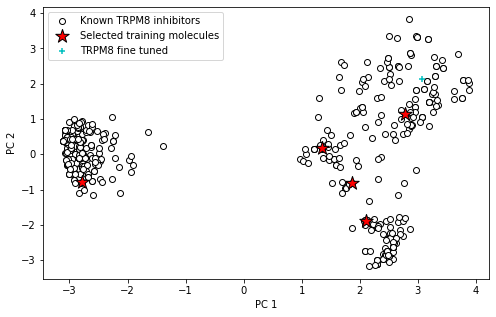

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:Klen, 0], X[:Klen, 1],
            c='w', edgecolors='k', label='Known TRPM8 inhibitors')
plt.scatter(X[Klen:Klen + Flen, 0], X[Klen:Klen + Flen, 1],
            s=200, c='r', marker='*', edgecolors='k', label='Selected training molecules')
plt.scatter(X[Klen + Flen:, 0], X[Klen + Flen:, 1],
            c='c', marker='+', label='TRPM8 fine tuned')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [ ]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [ ]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

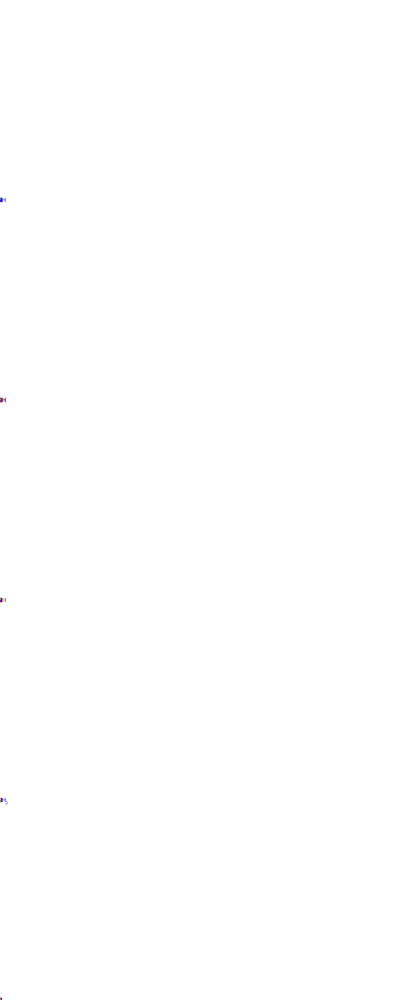

In [ ]:
Draw.MolsToGridImage(showmols, molsPerRow=2)